<a href="https://colab.research.google.com/github/rajikalk/Scripts/blob/master/N_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt

In [15]:
def getAcc( pos, mass, G, softening ):
	"""
    Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
	"""
	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r^3 for all particle pairwise particle separations 
	inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
	inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

	ax = np.dot(G * (dx * inv_r3), mass)#G * (dx * inv_r3) @ mass
	ay = np.dot(G * (dy * inv_r3), mass)#G * (dy * inv_r3) @ mass
	az = np.dot(G * (dz * inv_r3), mass)#G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))

	return a

In [16]:
def getEnergy( pos, vel, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Kinetic Energy:
	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return KE, PE;

In [17]:
# Simulation parameters
N         = 2    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 100.0   # time at which simulation ends
dt        = 0.1   # timestep
softening = 0.1    # softening length
G         = 1.0    # Newton's Gravitational Constant
plotRealTime = True # switch on for plotting as the simulation goes along

# Generate Initial Conditions
np.random.seed(17)            # set the random number generator seed

#Sun+Earth
mass = np.array([[1], [3.0404326462685257e-06]])
pos = np.array([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]])
vel = np.array([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

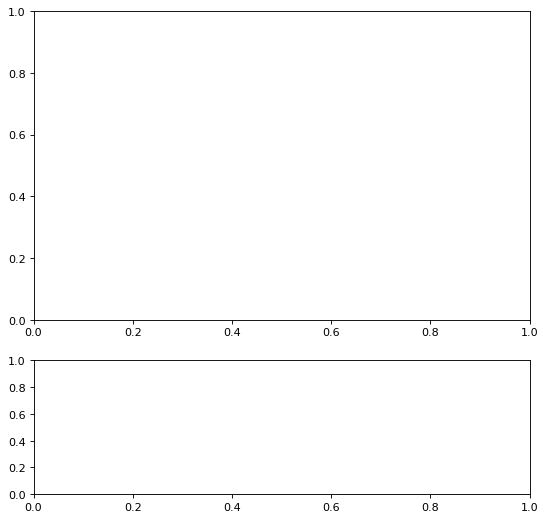

In [18]:
#run simulation
# Convert to Center-of-Mass frame
vel -= np.mean(mass * vel,0) / np.mean(mass)

# calculate initial gravitational accelerations
acc = getAcc( pos, mass, G, softening )

# calculate initial energy of system
KE, PE  = getEnergy( pos, vel, mass, G )

# number of timesteps
Nt = int(np.ceil(tEnd/dt))

# save energies, particle orbits for plotting trails
pos_save = np.zeros((N,3,Nt+1))
pos_save[:,:,0] = pos
KE_save = np.zeros(Nt+1)
KE_save[0] = KE
PE_save = np.zeros(Nt+1)
PE_save[0] = PE
t_all = np.arange(Nt+1)*dt
x_pos = []
y_pos = []

# Simulation Main Loop
for i in range(Nt):
    # (1/2) kick
    vel += acc * dt/2.0
    
    # drift
    pos += vel * dt
    
    # update accelerations
    acc = getAcc( pos, mass, G, softening )
    
    # (1/2) kick
    vel += acc * dt/2.0
    
    # update time
    t += dt
    
    # get energy of system
    KE, PE  = getEnergy( pos, vel, mass, G )
    
    # save energies, positions for plotting trail
    pos_save[:,:,i+1] = pos
    KE_save[i+1] = KE
    PE_save[i+1] = PE
    
    # plot in real time
    axlim = 2
    if plotRealTime or (i == Nt-1):
        #plt.sca(ax1)
        plt.cla()
        xx = pos_save[:,0,max(i-50,0):i+1]
        yy = pos_save[:,1,max(i-50,0):i+1]
        x_pos.append(xx)
        y_pos.append(yy)


In [40]:
print(y_pos[100].T[0])

[ 3.06882849e-06 -1.00933941e+00]


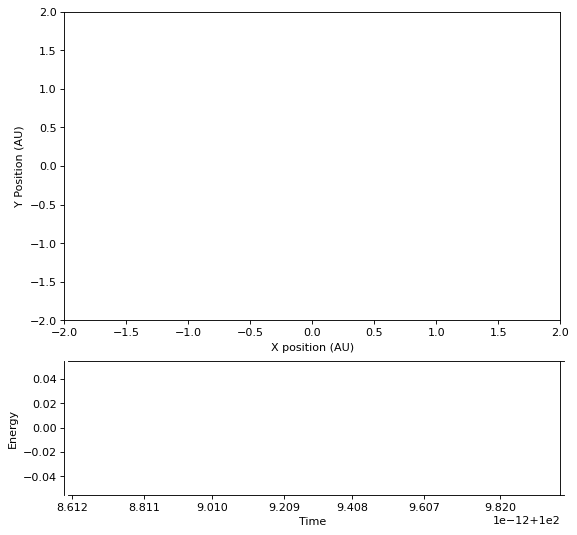

In [82]:
# create a figure and axes
fig = plt.figure(figsize=(8,8), dpi=80)
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
ax1 = plt.subplot(grid[0:2,0])
ax2 = plt.subplot(grid[2,0])
axlim = 2

# set up the subplots as needed
ax1.set_xlim((-1*axlim, axlim))            
ax1.set_ylim((-1*axlim, axlim))
ax1.set_xlabel('X position (AU)')
ax1.set_ylabel('Y Position (AU)')

ax2.set_xlim((t,tEnd))
#ax2.set_ylim((-2,2))
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
#ax2.set_title('Energy Evolution')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
#pt1, = ax2.plot([], [], 'g.', ms=20)
nbody, = ax1.plot([], [], 'g.', ms=20)     # ax.plot returns a list of 2D line objects
tail, = ax1.plot([], [], 'g.', ms=10, alpha=0.5, ls=None)
KE_evol, = ax2.plot([], [], 'b-', lw=2)
PE_evol, = ax2.plot([], [], 'r-', lw=2)

In [83]:
# animation function. This is called sequentially
def drawframe(n):
    x = x_pos[n][0]
    y = y_pos[n][0]
    nbody.set_data(x, y)
    tailx = x_pos[n][1:]
    taily = y_pos[n][1:]
    tail.set_data(tailx, taily)
    t_x = t_all[:n]
    KE = KE_save[:n]
    PE = PE_save[:n]
    KE_evol.set_data(t_x, KE)
    PE_evol.set_data(t_x, PE)
    ax1.set_aspect('equal')


    #y1 = np.sin(2 * np.pi * (x - 0.01 * n))
    #y2 = np.cos(2 * np.pi * (x - 0.01 * n))
    #line1.set_data(x, y1)
    #line2.set_data(x, y2)
    #line3.set_data(y1[0:50],y2[0:50])
    #pt1.set_data(y1[0],y2[0])
    #txt_title.set_text('Frame = {0:4d}'.format(n))
    return (nbody, KE_evol, PE_evol)

In [84]:
anim = animation.FuncAnimation(fig, drawframe, frames=Nt, blit=True)

In [85]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [72]:
print(PE_save[:10])

[-3.04043265e-06 -3.04017062e-06 -3.03938763e-06 -3.03809282e-06
 -3.03630131e-06 -3.03403387e-06 -3.03131659e-06 -3.02818047e-06
 -3.02466089e-06 -3.02079705e-06]


In [74]:
print(x_pos[10][0])

[0.00000000e+00 1.49769483e-08 5.97526129e-08 1.33863529e-07
 2.36544127e-07 3.66736876e-07 5.23106148e-07 7.04055516e-07
 9.07748078e-07 1.13212941e-06 1.37495266e-06]
